In [22]:
import os
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

from langchain_openai import AzureChatOpenAI

from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

In [23]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [24]:
tool = TavilySearchResults(max_results=2)
tools = [tool]

In [25]:
llm = AzureChatOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version=os.getenv("API_VERSION"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    model=os.getenv("MODEL_NAME"),
    )
llm_with_tools = llm.bind_tools(tools)

In [26]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [27]:
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [28]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [29]:
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ tools, if desired.
    # interrupt_after=["tools"]
)

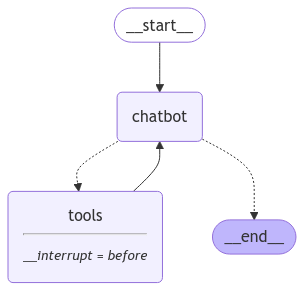

In [30]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [31]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_llCH4EQ65cYwk5u6LlB4pPdh)
 Call ID: call_llCH4EQ65cYwk5u6LlB4pPdh
  Args:
    query: LangGraph


In [32]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [33]:
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph'},
  'id': 'call_llCH4EQ65cYwk5u6LlB4pPdh',
  'type': 'tool_call'}]

In [36]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_llCH4EQ65cYwk5u6LlB4pPdh)
 Call ID: call_llCH4EQ65cYwk5u6LlB4pPdh
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.langchain.com/langgraph", "content": "LangGraph is a stateful, orchestration framework that brings added control to agent workflows. LangGraph Platform is a service for deploying and scaling LangGraph applications, with an opinionated API for building agent UXs, plus an integrated developer studio."}, {"url": "https://www.datacamp.com/tutorial/langgraph-tutorial", "content": "LangGraph is a library within the LangChain ecosystem that simplifies the development of complex, multi-agent large language model (LLM) applications. Learn how to use LangGraph to create stateful, flexible, and scalable systems with nodes, edges, and state man